# Despiking Data
## Import necessary modules

In [47]:
import numpy as np
import pandas as pd
from pandas import read_csv

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib notebook

RE = 6378.137 # Earth radoius in km

Import the data from CSV file. `pandas.read_csv` is more versatile than e.g. `numpy.genfromtxt`. Convert the column epoch to datetime object.

* `norad`: NORAD catalogue ID
* `name`: object name
* `time`: time differnce between epoch and launch date (pd.timedelta64 object in nanoseconds)
* `alt`: mean altitude, calculated from the difference of the semimajor axis and the Earth radius `RE` [km]

In [48]:
datafile="data/2020-062.dat"
launch_date = "2020-09-03 12:46:14"

data_all = read_csv(datafile, delimiter=',', quotechar='"', names=["norad","name","time","alt"])

data_all['time'] = pd.to_datetime(data_all['time']) - pd.to_datetime(launch_date)
data_all['alt'] = data_all['alt'] - RE

See what we got:

In [49]:
data_all

,norad,name,time,alt
0,46325,STARLINK-1734,4 days 08:21:24,224.134
1,46325,STARLINK-1734,4 days 18:43:56,225.970
2,46325,STARLINK-1734,4 days 21:42:08,228.638
3,46325,STARLINK-1734,5 days 00:40:17,228.914
4,46325,STARLINK-1734,5 days 07:13:47,228.982
...,...,...,...,...
49093,46388,FALCON 9 DEB,24 days 00:47:38,198.854
49094,46388,FALCON 9 DEB,24 days 14:02:43,191.379
49095,46388,FALCON 9 DEB,24 days 18:27:23,187.438
49096,46388,FALCON 9 DEB,24 days 22:51:49,183.387


Filter data for one object (given by specific NORAD catalogue ID)

In [58]:
norad = 46325
#norad = 46440
#norad = 47023
obj = data_all.query('norad == @norad')
obj

,norad,name,time,alt
0,46325,STARLINK-1734,4 days 08:21:24,224.134
1,46325,STARLINK-1734,4 days 18:43:56,225.970
2,46325,STARLINK-1734,4 days 21:42:08,228.638
3,46325,STARLINK-1734,5 days 00:40:17,228.914
4,46325,STARLINK-1734,5 days 07:13:47,228.982
...,...,...,...,...
542,46325,STARLINK-1734,352 days 22:07:52,547.214
543,46325,STARLINK-1734,354 days 02:47:34,547.204
544,46325,STARLINK-1734,354 days 18:42:58,547.195
545,46325,STARLINK-1734,356 days 02:33:44,547.181


Plot the semimajor axis over time.
`obj['time']` is of type `pd.timedelta64` and is the time difference in nanoseconds. For plotting, the value is transferred to days (after launch).

<IPython.core.display.Javascript object>


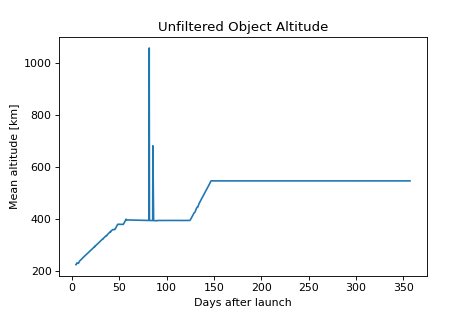

Text(0, 0.5, 'Mean altitude [km]')

In [59]:
alt = plt.figure()
ax = alt.add_subplot()
ax.plot(obj['time'] / timedelta(days=1), obj['alt'], "-")
ax.set_title("Unfiltered Object Altitude")
ax.set_xlabel("Days after launch")
ax.set_ylabel("Mean altitude [km]")

## Filtering using Threshold for the 1st Derivative
Calculate the absolute value of the first derivative `abs_deriv` of alt in m/s and add this data as a new column to the dataframe `obj`. The derivative is calculated using __[`numpy.gradient`](https://numpy.org/doc/stable/reference/generated/numpy.gradient.html)__.

`obj['time'] / timedelta(seconds=1)` converts from `pandas.timedelta64` to seconds.

In [60]:
abs_deriv = abs(np.gradient(obj['alt'] * 1E3, obj['time'] / timedelta(seconds=1), edge_order = 1))
obj = obj.assign(abs_deriv = abs_deriv)

Plot the absolute value of the derivative.

<IPython.core.display.Javascript object>


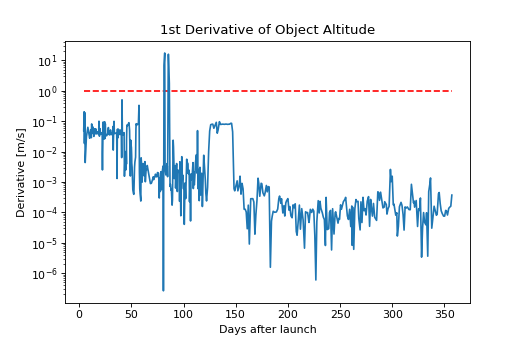

In [61]:
deriv = plt.figure()
ax = deriv.add_subplot()
ax.plot(obj['time'] / timedelta(days=1), obj['abs_deriv'], "-")
ax.set_yscale('log')
ax.set_title("1st Derivative of Object Altitude")
ax.set_xlabel("Days after launch")
ax.set_ylabel("Derivative [m/s]")

deriv_threshold = 1
tmin = obj['time'].min() / timedelta(days=1)
tmax = obj['time'].max() / timedelta(days=1)
ax.hlines(deriv_threshold, tmin, tmax, colors = 'r', linestyles = 'dashed')

Filter the altitude data using `deriv_threshold`. `obj['alt_derivfilt']` is a copy of `obj['alt_derivfilt']` with values set to nan (not a number) of `abs_deriv` exceeds `deriv_threshold`.

In [65]:
# Create new column
obj = obj.assign(alt_derivfilt = obj['alt'])
# Set outliers to nan
obj.loc[(obj.abs_deriv > deriv_threshold), 'alt_derivfilt'] = np.nan

<IPython.core.display.Javascript object>


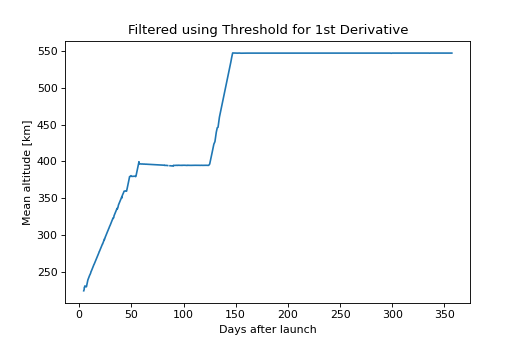

Text(0, 0.5, 'Mean altitude [km]')

In [67]:
alt_filt1 = plt.figure()
ax = alt_filt1.add_subplot()
ax.plot(obj['time'] / timedelta(days=1), obj['alt_derivfilt'], "-")
ax.set_title("Filtered using Threshold for 1st Derivative")
ax.set_xlabel("Days after launch")
ax.set_ylabel("Mean altitude [km]")

## Filtering using Moving Median

Define function for custom moving median filter `movmedian`. The argument `boxhw` defines the width of the box for the filter. The width is `2 * boxhw + 1`, which ensures, that the box width is always uneven, if the box is not touching the boundaries.

In [71]:
def movmedian(data, boxhw):
    data_filtered = []

    for i in range(0,len(data)):
        # Lower boundary
        lb = i - boxhw if i >= boxhw else 0
        # Upper boundary
        ub = i + boxhw if i + boxhw < len(data) else len(data)-1
        # Calculate median from array slice (sliding window)
        data_filtered.append(np.median(data[lb:ub+1]))
        #print(i, lb, ub, data[lb:ub+1], np.median(data[lb:ub+1]))

    return data_filtered

Apply filter to `obj['alt']` and create new column `obj['alt_mmfilt']` in dataframe.

In [72]:
box_half_width = 5
obj = obj.assign(alt_mmfilt = movmedian(obj['alt'], box_half_width))

<IPython.core.display.Javascript object>


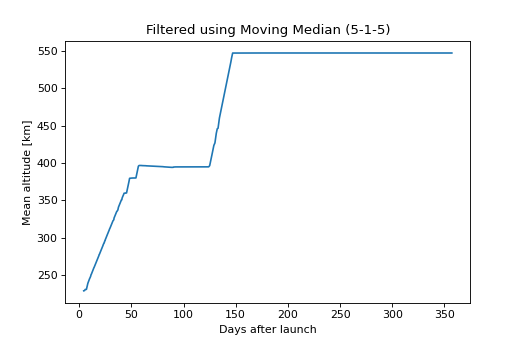

Text(0, 0.5, 'Mean altitude [km]')

In [73]:
alt_filt2 = plt.figure()
ax = alt_filt2.add_subplot()
ax.plot(obj['time'] / timedelta(days=1), obj['alt_mmfilt'], "-")
title = (
    "Filtered using Moving Median ("
    + str(box_half_width)
    + "-1-"
    + str(box_half_width)
    + ")"
)
ax.set_title(title)
ax.set_xlabel("Days after launch")
ax.set_ylabel("Mean altitude [km]")